In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklift.metrics import uplift_at_k, qini_auc_score, uplift_by_percentile, weighted_average_uplift
from sklift.viz import plot_uplift_preds, plot_uplift_curve, plot_qini_curve, plot_uplift_by_percentile
from sklift.models import SoloModel, ClassTransformation, TwoModels

from catboost import CatBoostClassifier

In [2]:
df = pd.read_csv('data.csv')

In [3]:
df.rename(columns = {'conversion': 'target', 'offer': 'treatment'}, inplace = True)

In [4]:
df['treatment'] = df['treatment'].apply(lambda x: 0 if x == 'No Offer' else 1)

In [5]:
df_train, df_test = train_test_split(df, test_size = 0.33, random_state = 42)

indices_train = df_train.index
indices_test = df_test.index

indices_learn, indices_valid = train_test_split(indices_train, test_size = 0.33, random_state = 42)


In [6]:
X_train = df_train.loc[indices_learn, :].drop(['treatment', 'target'], axis=1)
y_train = df_train.loc[indices_learn, 'target']
treat_train = df_train.loc[indices_learn, 'treatment']

X_val = df_train.loc[indices_valid, :].drop(['treatment', 'target'], axis=1)
y_val = df_train.loc[indices_valid, 'target']
treat_val = df_train.loc[indices_valid, 'treatment']

X_test = df_test.loc[indices_test, :].drop(['treatment', 'target'], axis=1)
y_test = df_test.loc[indices_test, 'target']
treat_test = df_test.loc[indices_test, 'treatment']

In [7]:
cat_features = ['zip_code', 'channel']
uplift_10, uplift_20 = [], []

### <b> SoloModel

In [8]:
sm = SoloModel(
    CatBoostClassifier(iterations=20, random_state=42, silent=True, cat_features=cat_features)
)

In [9]:
sm.fit(X_train, y_train, treat_train)

uplift_sm = sm.predict(X_val)

sm_score_10 = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.1)
sm_score_20 = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.2)

uplift_10.append(sm_score_10)
uplift_20.append(sm_score_20)

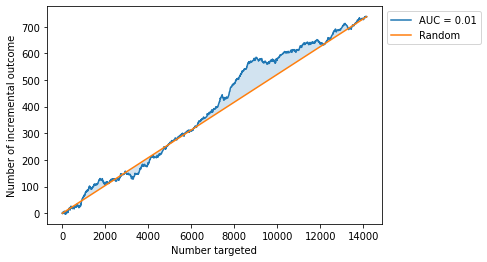

In [14]:
plot_uplift_curve(y_val, uplift_sm, treat_val, perfect = False)
plt.show()

### <b> Z-transformation

In [16]:
from sklift.models import ClassTransformation


ct = ClassTransformation(
    CatBoostClassifier(iterations=20, random_state=42, silent=True, cat_features=cat_features)
)
ct = ct.fit(X_train, y_train, treat_train)

uplift_ct = ct.predict(X_val)

ct_score_10 = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.1)
ct_score_20 = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.2)

uplift_10.append(ct_score_10)
uplift_20.append(ct_score_20)


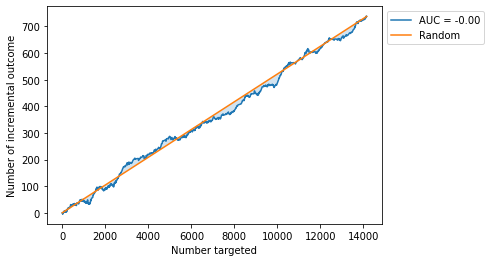

In [17]:
plot_uplift_curve(y_val, uplift_ct, treat_val, perfect = False)
plt.show()

In [18]:
ct_score_10, ct_score_20

(0.04278074866310161, 0.05899127473930624)

### <b> TwoModel

In [20]:
tm = TwoModels(
    CatBoostClassifier(iterations=20, random_state=42, silent=True, cat_features=cat_features),
    CatBoostClassifier(iterations=20, random_state=42, silent=True, cat_features=cat_features),
    method='vanilla'  # независимые модели
)
tm = tm.fit(
    X_train, y_train, treat_train
)

uplift_tm = tm.predict(X_val)

tm_score_10 = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.1)
tm_score_20 = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.2)

uplift_10.append(tm_score_10)
uplift_20.append(tm_score_20)

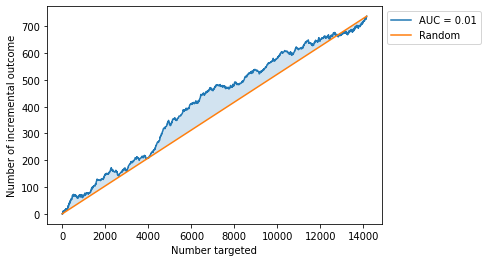

In [21]:
plot_uplift_curve(y_val, uplift_tm, treat_val, perfect = False)
plt.show()

In [22]:
tm_score_10, tm_score_20

(0.0703781512605042, 0.05896573739093425)

In [23]:
results = pd.DataFrame({'Uplift_at_10%': uplift_10, 'Uplift_at_20%': uplift_20}, index = ['SoloModel', 'Z-tranform', 'TwoModel'], columns = ['Uplift_at_10%', 'Uplift_at_20%'])
results

,Uplift_at_10%,Uplift_at_20%
SoloModel,0.072033,0.052042
Z-tranform,0.042781,0.058991
TwoModel,0.070378,0.058966


In [24]:
uplift_test = sm.predict(X_test)

In [26]:
X_test['uplift'] = uplift_test
X_test['target'] = y_test

In [27]:
X_test.sort_values(by= 'uplift', ascending = False, inplace = True)

In [28]:
X_test['decile'] = pd.qcut(X_test['uplift'], q=10, labels = [str(x)+'0%' for x in range(1, 11)])

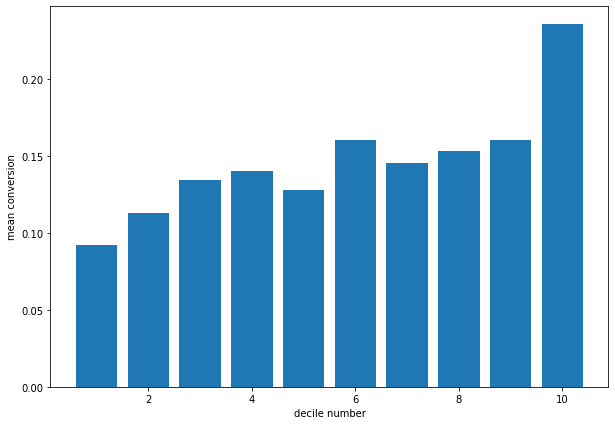

In [29]:
mean_conv_list = []

for x in range(1, 11):
    mean_conv_list.append(X_test.loc[X_test['decile'] == str(x)+'0%', 'target'].mean())
    
plt.figure(figsize = (10, 7))
plt.bar(range(1, 11), mean_conv_list)
plt.xlabel('decile number')
plt.ylabel('mean conversion')
plt.show()
    